<a href="https://colab.research.google.com/github/nsambel1980/causal_discovery/blob/main/PAC_bound_advesarial_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adversarial Training, PAC bounds:

#### This script demonstrates adversarial training techniques to improve the robustness of
#### a simple neural network against adversarial examples. It covers generating adversarial
#### examples using methods like FGSM and PGD, incorporating them into the training process,
#### and evaluating the model's performance against various attacks.

#### Additionally, the script explores the concept of PAC bounds to provide guidance (e.g. in some cases, theoretical guarantee)
#### about the model's generalization ability and robustness in the presence of adversaries.

### <b>Reasonably easy to change data and netowrk architecture for other problems.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =====================================================
# Data Generation and Preprocessing
# =====================================================

def generate_dataset():
    """Generate a synthetic dataset for binary classification."""
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, scaler

# =====================================================
# Model Creation
# =====================================================

def create_model(input_dim, hidden_units=32, dropout_rate=0.0):
    """Create a simple neural network model."""
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(input_dim,)),
        Dense(hidden_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# =====================================================
# Adversarial Example Generation
# =====================================================

def fgsm_attack(model, x, y, epsilon=0.1):
    """
    Fast Gradient Sign Method attack.
    Creates adversarial examples by adding noise in the direction that maximizes loss.
    """
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        prediction = model(x_tensor)
        y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
        y_tensor = tf.reshape(y_tensor, (-1, 1))
        loss = tf.keras.losses.binary_crossentropy(y_tensor, prediction)

    # Get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, x_tensor)

    # Create the perturbation by taking the sign of the gradient
    signed_grad = tf.sign(gradient)

    # Add perturbation to original example to create adversarial example
    x_adv = x_tensor + epsilon * signed_grad

    return x_adv.numpy()

def pgd_attack(model, x, y, epsilon=0.1, alpha=0.01, num_iter=10):
    """
    Projected Gradient Descent attack.
    A more powerful iterative variant of FGSM.
    """
    x_adv = x.copy()
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

    for i in range(num_iter):
        with tf.GradientTape() as tape:
            x_adv_tensor = tf.convert_to_tensor(x_adv, dtype=tf.float32)
            tape.watch(x_adv_tensor)
            prediction = model(x_adv_tensor)
            y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
            y_tensor = tf.reshape(y_tensor, (-1, 1))
            loss = tf.keras.losses.binary_crossentropy(y_tensor, prediction)

        # Get gradients
        gradient = tape.gradient(loss, x_adv_tensor)

        # Update adversarial example
        x_adv = x_adv_tensor + alpha * tf.sign(gradient)

        # Project back to epsilon ball
        x_adv = x_tensor + tf.clip_by_value(x_adv - x_tensor, -epsilon, epsilon)
        x_adv = x_adv.numpy()

    return x_adv

def random_noise_attack(x, epsilon=0.1, noise_type = 'gaussian'):
    """Simple attack that adds random noise to inputs."""
    if noise_type == 'uniform':
       noise = np.random.uniform(-epsilon, epsilon, size=x.shape)
    elif noise_type == 'gaussian':
        noise = np.random.normal(0, epsilon, size=x.shape) # you can add mean to check shift sensitivity
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")
    return x + noise

def generate_adversarial_examples(model, x, y, attack_type='fgsm', epsilon=0.1, noise_type='gaussian'):
    """Generate adversarial examples using specified attack."""
    if attack_type == 'fgsm':
        return fgsm_attack(model, x, y, epsilon)
    elif attack_type == 'pgd':
        return pgd_attack(model, x, y, epsilon)
    elif attack_type == 'random':
        return random_noise_attack(x, epsilon, noise_type = noise_type)
    else:
        raise ValueError(f"Unknown attack type: {attack_type}")

# =====================================================
# Adversarial Training
# =====================================================

def adversarial_training(model, X_train, y_train, attack_type='fgsm', epsilon=0.1,
                         batch_size=32, epochs=5, validation_data=None):
    """Train model with a mix of clean and adversarial examples."""
    n_samples = len(X_train)

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        start_time = time.time()

        # Shuffle data
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        epoch_loss = []
        epoch_acc = []

        # Train in batches
        for i in range(0, n_samples, batch_size):
            end = min(i + batch_size, n_samples)
            X_batch = X_shuffled[i:end]
            y_batch = y_shuffled[i:end]

            # Generate adversarial examples
            X_adv = generate_adversarial_examples(model, X_batch, y_batch,
                                                attack_type, epsilon)

            # Combine clean and adversarial examples
            X_combined = np.concatenate([X_batch, X_adv])
            y_combined = np.concatenate([y_batch, y_batch])

            # Train on batch
            batch_metrics = model.train_on_batch(X_combined, y_combined)
            epoch_loss.append(batch_metrics[0])
            epoch_acc.append(batch_metrics[1])

        # Track metrics
        avg_loss = np.mean(epoch_loss)
        avg_acc = np.mean(epoch_acc)
        history['loss'].append(avg_loss)
        history['accuracy'].append(avg_acc)

        # Validation
        if validation_data is not None:
            X_val, y_val = validation_data
            val_metrics = model.evaluate(X_val, y_val, verbose=0)
            history['val_loss'].append(val_metrics[0])
            history['val_accuracy'].append(val_metrics[1])
            print(f"loss: {avg_loss:.4f} - accuracy: {avg_acc:.4f} - val_loss: {val_metrics[0]:.4f} - val_accuracy: {val_metrics[1]:.4f} - time: {time.time() - start_time:.2f}s")
        else:
            print(f"loss: {avg_loss:.4f} - accuracy: {avg_acc:.4f} - time: {time.time() - start_time:.2f}s")

    return history

# =====================================================
# Robust Evaluation and PAC Bounds
# =====================================================

def compute_error(model, X, y):
    """Compute classification error rate."""
    preds = (model.predict(X) >= 0.5).astype(int).flatten()
    return np.mean(preds != y)

def robust_evaluation(model, X_test, y_test, attack_types=['fgsm', 'pgd', 'random'],
                      epsilons=[0.01, 0.05, 0.1]):
    """Comprehensive adversarial testing suite."""
    results = {}

    # Baseline performance
    baseline_error = compute_error(model, X_test, y_test)
    results['baseline'] = baseline_error

    # Test against different attack types
    for attack in attack_types:
        attack_results = []
        for eps in epsilons:
            # Generate adversarial examples
            adv_examples = generate_adversarial_examples(
                model, X_test, y_test, attack_type=attack, epsilon=eps
            )

            # Evaluate model on adversarial examples
            adv_error = compute_error(model, adv_examples, y_test)
            attack_results.append((eps, adv_error))
            print(f"Attack: {attack}, Epsilon: {eps}, Error: {adv_error:.4f}")

        results[attack] = attack_results

    # Calculate robustness metrics
    all_errors = [err for _, err in sum([results[k] for k in attack_types], [])]
    results['worst_case_error'] = max(all_errors)
    results['avg_robustness_gap'] = np.mean([err - baseline_error for err in all_errors])

    return results

def compute_pac_bounds(baseline_error, n_train, delta=0.05, complexity_term=None, robustness_gap=None):
    """Compute various PAC bounds."""
    bounds = {}

    # Standard Hoeffding bound
    bounds['hoeffding'] = baseline_error + np.sqrt(np.log(2/delta) / (2 * n_train))

    # If we have a complexity term (can be VC dimension or Rademacher complexity)
    if complexity_term is not None:
        bounds['complexity_based'] = baseline_error + np.sqrt((complexity_term + np.log(1/delta)) / (2 * n_train))

    # Robustness-based bound
    if robustness_gap is not None:
        bounds['robust'] = baseline_error + robustness_gap + np.sqrt(np.log(1/delta) / (2 * n_train))

    return bounds

# =====================================================
# Visualization
# =====================================================

def plot_decision_boundary(model, X, y, title="Decision Boundary", ax=None):
    """Plot the decision boundary of the model."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    # Set min and max values for plotting grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # Create a mesh grid
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    # Make predictions on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour
    ax.contourf(xx, yy, Z, alpha=0.3)

    # Plot data points
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='viridis')

    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    return ax

def plot_adversarial_examples(model, X, y, X_adv, y_adv, indices, attack_type, epsilon):
    """Plot original vs adversarial examples."""
    fig, axes = plt.subplots(2, len(indices), figsize=(15, 7))

    for i, idx in enumerate(indices):
        # Original example
        axes[0, i].scatter(X[idx, 0], X[idx, 1], c='blue', s=100, marker='o')
        axes[0, i].set_title(f"Original\nTrue: {y[idx]}, Pred: {int(model.predict(X[idx:idx+1]) >= 0.5)}")

        # Adversarial example
        axes[1, i].scatter(X_adv[idx, 0], X_adv[idx, 1], c='red', s=100, marker='o')
        axes[1, i].set_title(f"Adversarial\nTrue: {y_adv[idx]}, Pred: {int(model.predict(X_adv[idx:idx+1]) >= 0.5)}")

    plt.suptitle(f"{attack_type.upper()} Attack (ε={epsilon})")
    plt.tight_layout()
    plt.show()

def plot_robustness_curves(results, attack_types, epsilons):
    """Plot error rates as a function of perturbation size."""
    plt.figure(figsize=(10, 6))

    plt.axhline(y=results['baseline'], linestyle='--', color='black', label='Baseline')

    for attack in attack_types:
        errors = [err for _, err in results[attack]]
        plt.plot(epsilons, errors, marker='o', label=attack.upper())

    plt.xlabel('Perturbation Size (ε)')
    plt.ylabel('Error Rate')
    plt.title('Robustness to Adversarial Perturbations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_bounds(bounds, results):
    """Plot different PAC bounds along with empirical errors."""
    labels = list(bounds.keys())
    values = list(bounds.values())

    baseline = results['baseline']
    worst_case = results['worst_case_error']

    plt.figure(figsize=(10, 6))

    # Plot empirical errors
    plt.axhline(y=baseline, linestyle='--', color='green', label='Clean Test Error')
    plt.axhline(y=worst_case, linestyle='--', color='red', label='Worst-case Adv. Error')

    # Plot bounds
    colors = ['blue', 'orange', 'purple', 'brown']
    for i, (label, value) in enumerate(zip(labels, values)):
        plt.bar(i, value, color=colors[i % len(colors)], alpha=0.7, label=f"{label.capitalize()} Bound")

    plt.xticks(range(len(labels)), [l.capitalize() for l in labels], rotation=45)
    plt.ylabel('Error Rate')
    plt.title('Comparison of PAC Bounds and Empirical Errors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



Generating dataset...
Creating model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Standard Training:
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7890 - loss: 0.6162 - val_accuracy: 0.8400 - val_loss: 0.5245
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8512 - loss: 0.4916 - val_accuracy: 0.8400 - val_loss: 0.4173
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8554 - loss: 0.3925 - val_accuracy: 0.8600 - val_loss: 0.3322
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8632 - loss: 0.3247 - val_accuracy: 0.8600 - val_loss: 0.2803
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8734 - loss: 0.2883 - val_accuracy: 0.8850 - val_loss: 0.2517
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8774 - loss: 0.2687 - val_accuracy: 0.9150 - val_loss: 0.2342
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8861 - loss: 0.2555 - val_accuracy: 0.9150 - val_loss: 0.2200
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8924 - loss: 0.2437 - val_

<Figure size 1000x800 with 0 Axes>

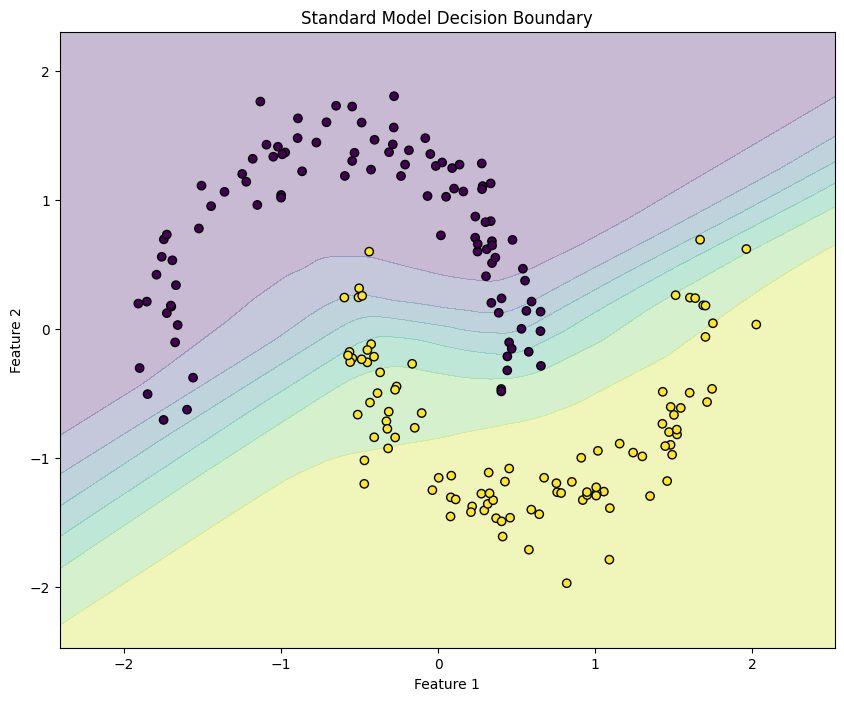


Performing robust evaluation on standard model...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Attack: fgsm, Epsilon: 0.01, Error: 0.0750
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Attack: fgsm, Epsilon: 0.05, Error: 0.0800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Attack: fgsm, Epsilon: 0.1, Error: 0.0950
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Attack: fgsm, Epsilon: 0.2, Error: 0.1650
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Attack: pgd, Epsilon: 0.01, Error: 0.0750
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Attack: pgd, Epsilon: 0.05, Error: 0.0800
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Attack: pgd, Epsilon: 0.1, Error: 0.0950
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Attack: pgd, Epsilon: 0.2, Error: 0.0950
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Attack: random, Epsilon: 0.01, Error: 0.0750
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Attack: random, Epsilon: 0.05, Error: 0.0650
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Attack: random, Epsilon: 0.1, Error: 0.0800
7/7 ━━━━━━━━━━━━━━━━━━━

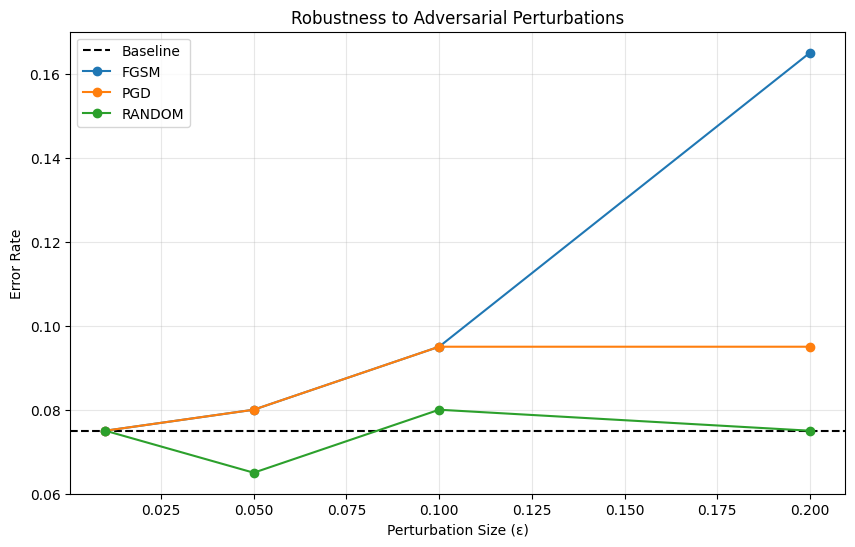


Visualizing PGD adversarial examples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

<ipython-input-1-2a9ed7f5d79d>:289: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[0, i].set_title(f"Original\nTrue: {y[idx]}, Pred: {int(model.predict(X[idx:idx+1]) >= 0.5)}")
<ipython-input-1-2a9ed7f5d79d>:293: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axes[1, i].set_title(f"Adversarial\nTrue: {y_adv[idx]}, Pred: {int(model.predict(X_adv[idx:idx+1]) >= 0.5)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


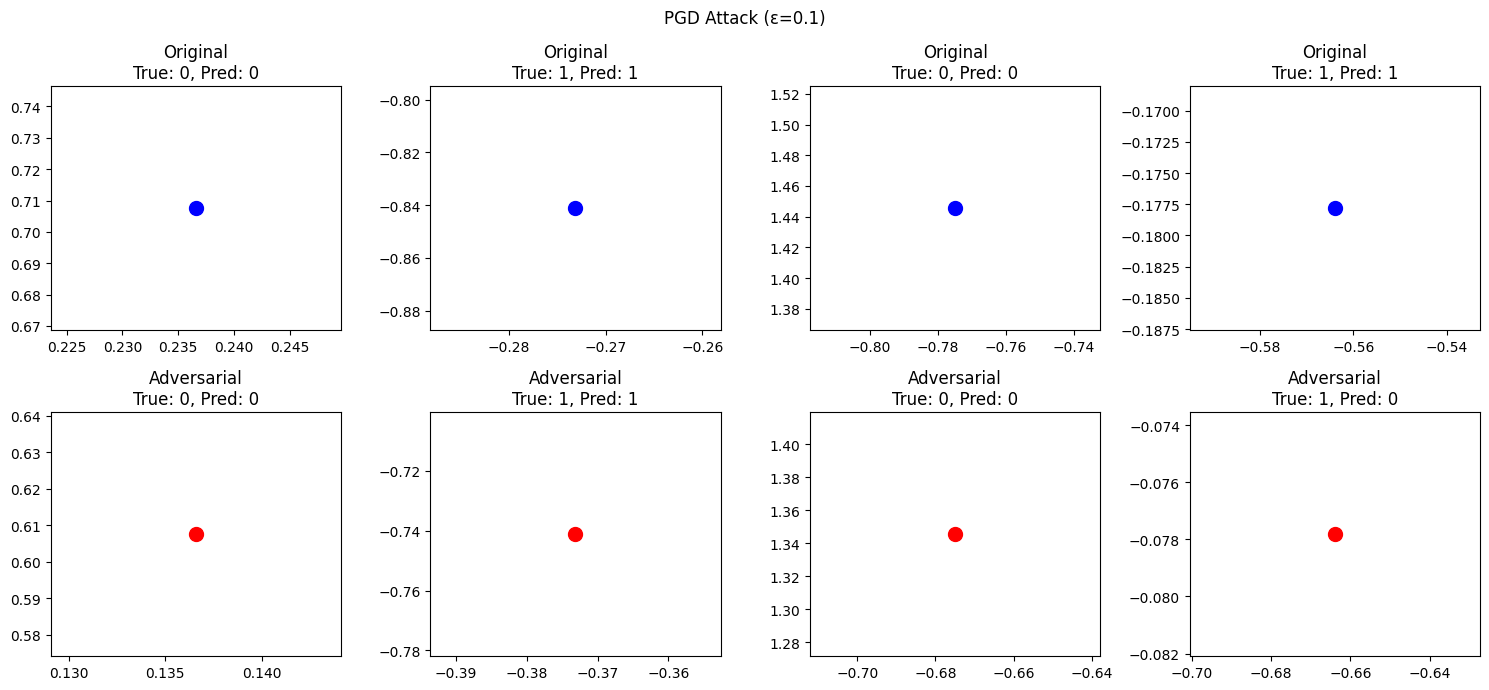


Standard Model PAC Bounds:
Hoeffding Bound: 0.1230
Robust Bound: 0.1312


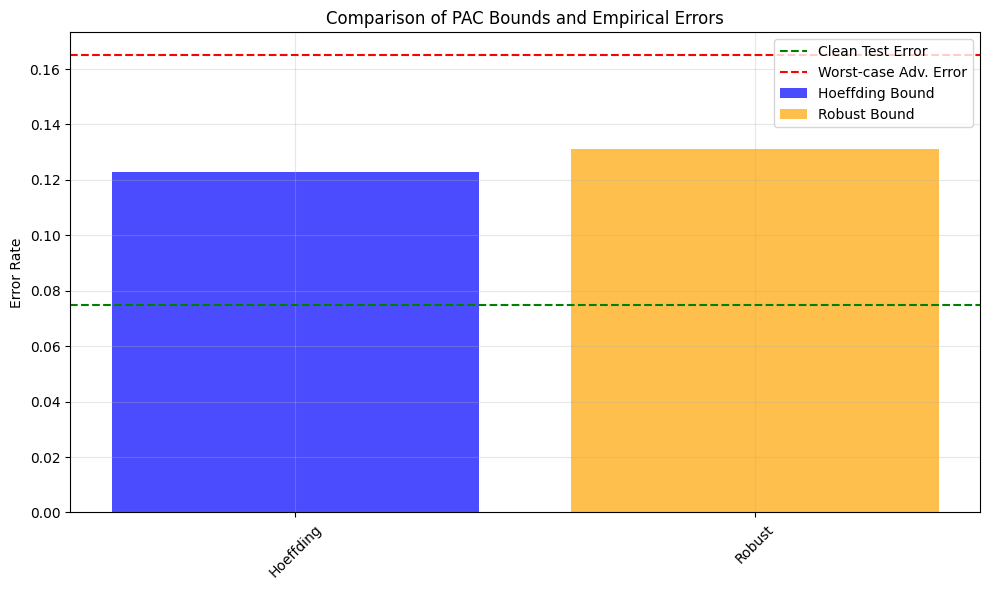


Performing adversarial training...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


loss: 0.6896 - accuracy: 0.5367 - val_loss: 0.5878 - val_accuracy: 0.8150 - time: 4.90s
Epoch 2/15
loss: 0.5709 - accuracy: 0.8329 - val_loss: 0.4817 - val_accuracy: 0.8400 - time: 4.12s
Epoch 3/15
loss: 0.4637 - accuracy: 0.8432 - val_loss: 0.3924 - val_accuracy: 0.8400 - time: 3.48s
Epoch 4/15
loss: 0.3870 - accuracy: 0.8432 - val_loss: 0.3286 - val_accuracy: 0.8450 - time: 3.32s
Epoch 5/15
loss: 0.3226 - accuracy: 0.8594 - val_loss: 0.2888 - val_accuracy: 0.8600 - time: 4.48s
Epoch 6/15
loss: 0.3054 - accuracy: 0.8647 - val_loss: 0.2662 - val_accuracy: 0.8650 - time: 3.77s
Epoch 7/15
loss: 0.2718 - accuracy: 0.8813 - val_loss: 0.2524 - val_accuracy: 0.8750 - time: 3.79s
Epoch 8/15
loss: 0.2750 - accuracy: 0.8711 - val_loss: 0.2425 - val_accuracy: 0.8850 - time: 4.15s
Epoch 9/15
loss: 0.2462 - accuracy: 0.8878 - val_loss: 0.2328 - val_accuracy: 0.8900 - time: 4.20s
Epoch 10/15
loss: 0.2688 - accuracy: 0.8671 - val_loss: 0.2243 - val_accuracy: 0.9050 - time: 3.51s
Epoch 11/15
loss: 0.

<Figure size 1000x800 with 0 Axes>

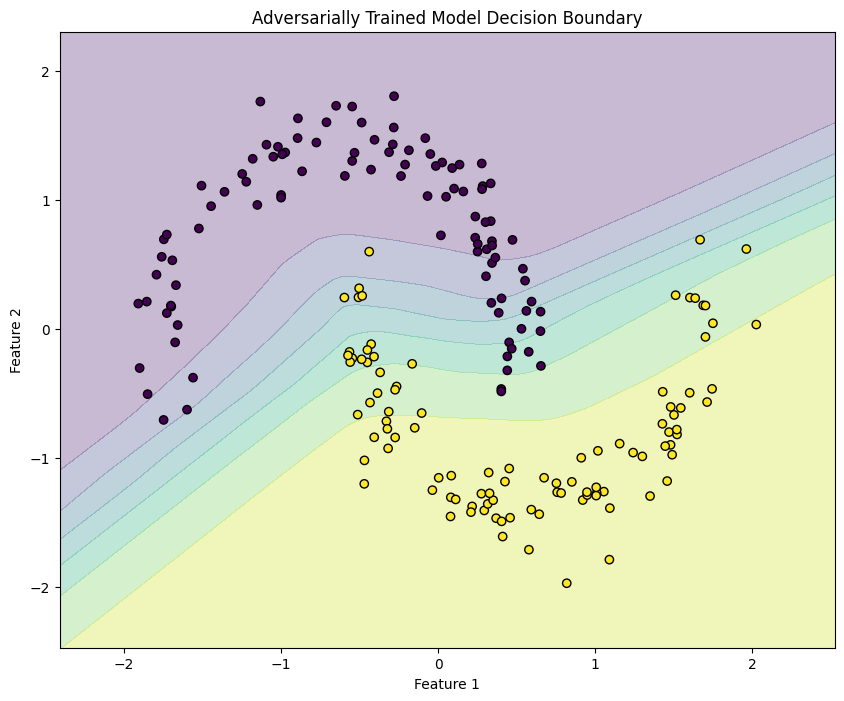

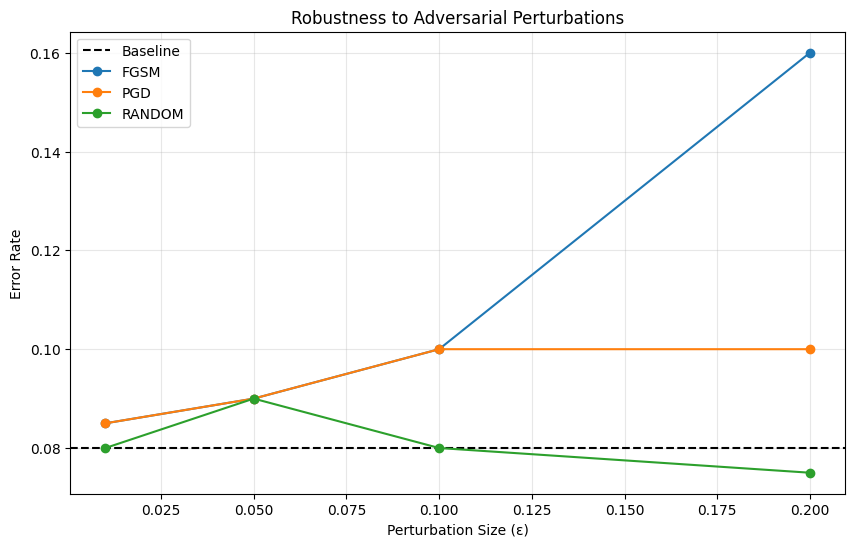


Robust Model PAC Bounds:
Hoeffding Bound: 0.1280
Robust Bound: 0.1379


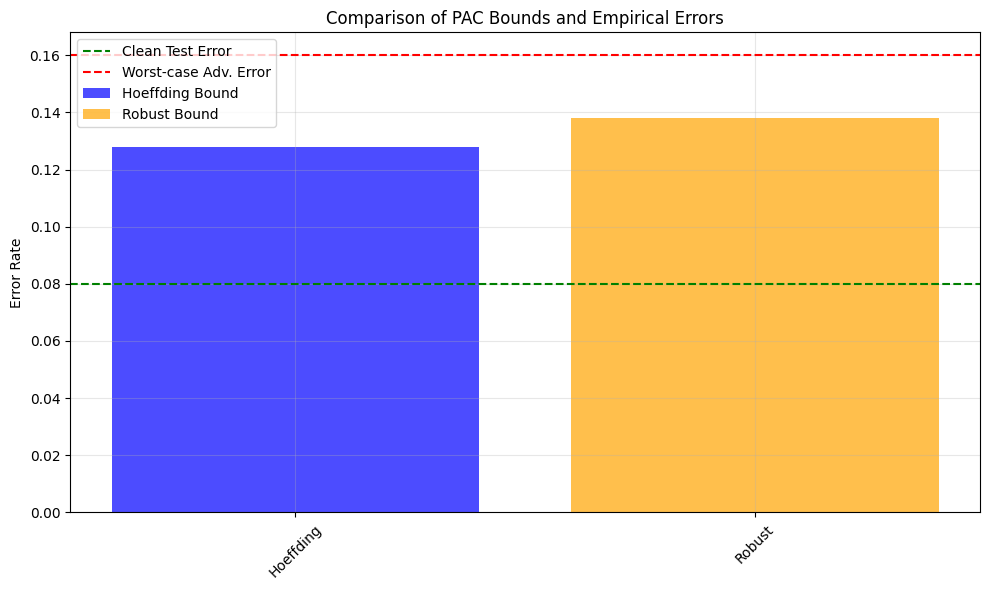


Comparison of Standard vs Robust Models:
Standard model worst-case error: 0.1650
Robust model worst-case error: 0.1600
Improvement: 0.0050
Standard model robust bound: 0.1312
Robust model robust bound: 0.1379
Bound improvement: -0.0067


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


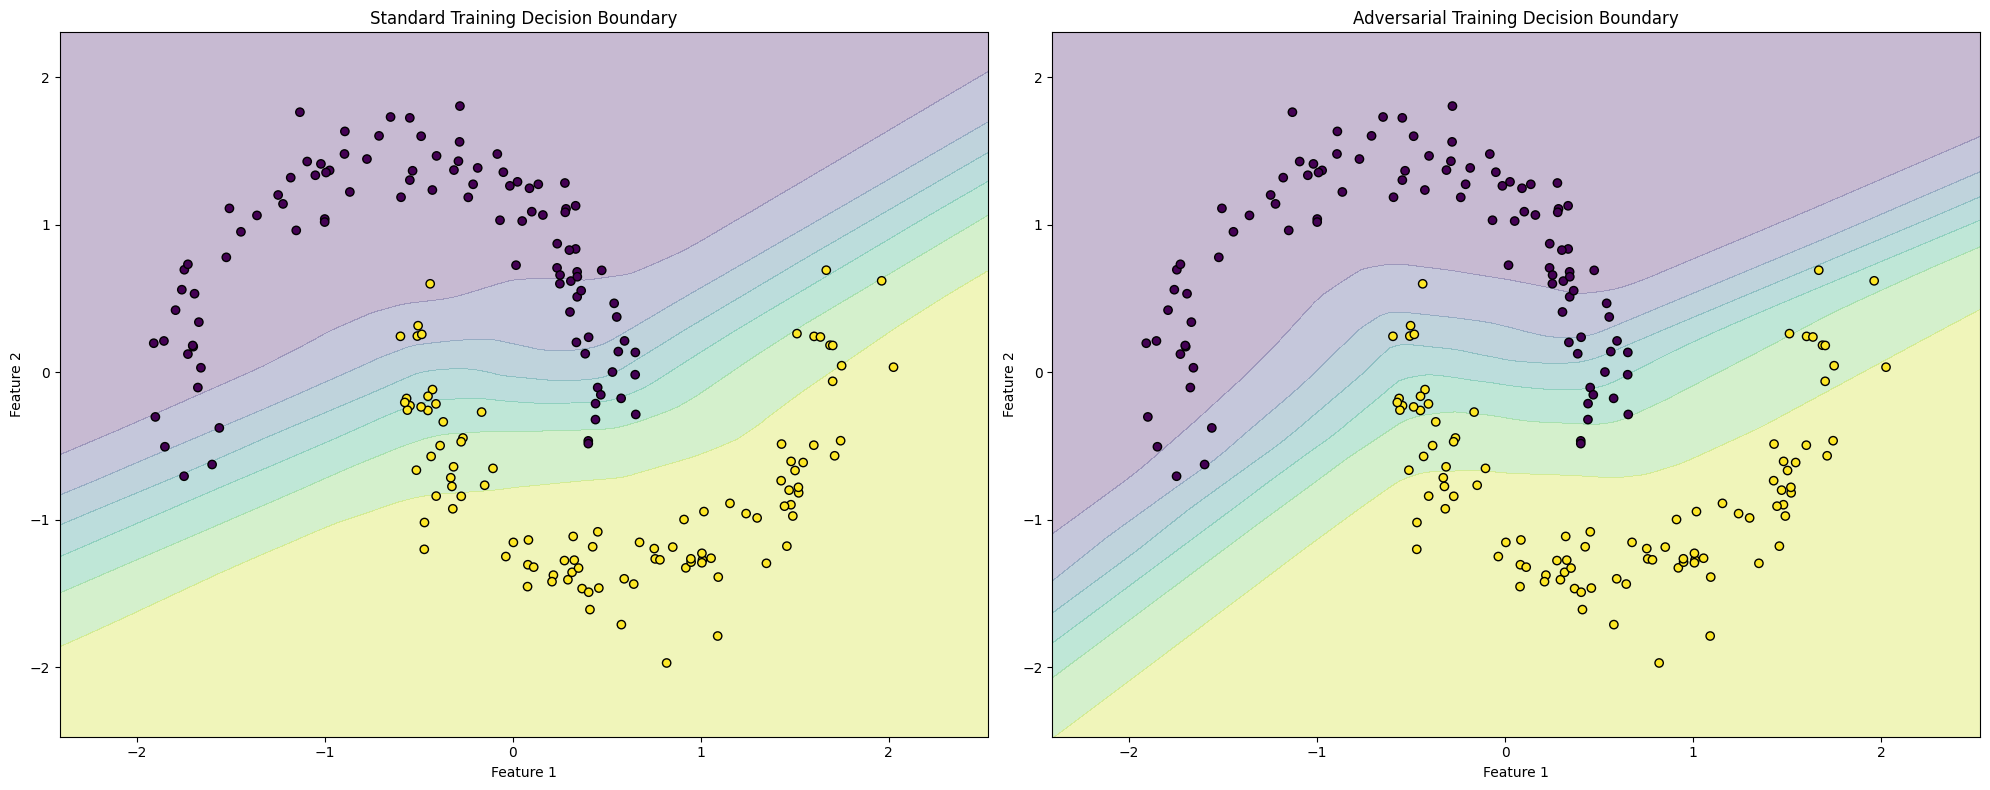

In [2]:
# =====================================================
# Main Execution
# =====================================================

def main():
    # Generate dataset
    print("Generating dataset...")
    X_train, X_test, y_train, y_test, scaler = generate_dataset()

    # Create model
    print("Creating model...")
    model = create_model(input_dim=X_train.shape[1])

    # Standard training first
    print("\nStandard Training:")
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),
             verbose=1)

    # Evaluate on clean test data
    clean_loss, clean_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nClean Test Accuracy: {clean_acc:.4f}")

    # Visualize decision boundary
    plt.figure(figsize=(10, 8))
    plot_decision_boundary(model, X_test, y_test, "Standard Model Decision Boundary")
    plt.show()

    # Perform robust evaluation
    print("\nPerforming robust evaluation on standard model...")
    attack_types = ['fgsm', 'pgd', 'random']
    epsilons = [0.01, 0.05, 0.1, 0.2] # these values depend on the problem at hand
    standard_results = robust_evaluation(model, X_test, y_test, attack_types, epsilons)

    # Plot robustness curves
    plot_robustness_curves(standard_results, attack_types, epsilons)

    # Visualize some adversarial examples
    adversarial_epsilon      = 0.1   # problem specific
    adversarial_attack_type = 'pgd' # this is the choice you need to make what to be robust against
    print(f"\nVisualizing {adversarial_attack_type.upper()} adversarial examples...")

    idx = np.random.choice(len(X_test), 4, replace=False)
    X_adv = generate_adversarial_examples(model, X_test, y_test, attack_type=adversarial_attack_type, epsilon = adversarial_epsilon )
    plot_adversarial_examples(model, X_test, y_test, X_adv, y_test, idx, attack_type=adversarial_attack_type, epsilon = adversarial_epsilon)

    # Compute PAC bounds
    n_train = len(X_train)
    standard_bounds = compute_pac_bounds(
        standard_results['baseline'],
        n_train,
        complexity_term=None,  # Proxy for model complexity
        robustness_gap=standard_results['avg_robustness_gap']
    )

    print("\nStandard Model PAC Bounds:")
    for bound_name, bound_value in standard_bounds.items():
        print(f"{bound_name.capitalize()} Bound: {bound_value:.4f}")

    plot_bounds(standard_bounds, standard_results)

    # Now train with adversarial training
    print("\nPerforming adversarial training...")
    # Reset model
    model = create_model(input_dim=X_train.shape[1])

    # Adversarial training
    adv_history = adversarial_training(
        model, X_train, y_train,
        attack_type=adversarial_attack_type,
        epsilon=adversarial_epsilon,
        batch_size=32,
        epochs=15,
        validation_data=(X_test, y_test)
    )

    # Evaluate adversarially trained model
    print("\nPerforming robust evaluation on adversarially trained model...")
    robust_results = robust_evaluation(model, X_test, y_test, attack_types, epsilons)

    # Visualize decision boundary after adversarial training
    plt.figure(figsize=(10, 8))
    plot_decision_boundary(model, X_test, y_test, "Adversarially Trained Model Decision Boundary")
    plt.show()

    # Plot robustness curves for adversarially trained model
    plot_robustness_curves(robust_results, attack_types, epsilons)

    # Compute PAC bounds for robust model
    robust_bounds = compute_pac_bounds(
        robust_results['baseline'],
        n_train,
        complexity_term=None,  # May be higher due to adversarial training
        robustness_gap=robust_results['avg_robustness_gap']
    )

    print("\nRobust Model PAC Bounds:")
    for bound_name, bound_value in robust_bounds.items():
        print(f"{bound_name.capitalize()} Bound: {bound_value:.4f}")

    plot_bounds(robust_bounds, robust_results)

    # Compare bounds
    print("\nComparison of Standard vs Robust Models:")
    print(f"Standard model worst-case error: {standard_results['worst_case_error']:.4f}")
    print(f"Robust model worst-case error: {robust_results['worst_case_error']:.4f}")
    print(f"Improvement: {standard_results['worst_case_error'] - robust_results['worst_case_error']:.4f}")

    print(f"Standard model robust bound: {standard_bounds['robust']:.4f}")
    print(f"Robust model robust bound: {robust_bounds['robust']:.4f}")
    print(f"Bound improvement: {standard_bounds['robust'] - robust_bounds['robust']:.4f}")

    # Compare decision boundaries side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Create and save the standard model
    standard_model = create_model(input_dim=X_train.shape[1])
    standard_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Plot standard model decision boundary
    plot_decision_boundary(standard_model, X_test, y_test, "Standard Training Decision Boundary", ax=axes[0])

    # Plot adversarially trained model decision boundary
    plot_decision_boundary(model, X_test, y_test, "Adversarial Training Decision Boundary", ax=axes[1])

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()